Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
traded_symbol = 'ETHBTC'
symbols = {'ETHBTC': None, 'BTCUSDT': None, 'ETHUSDT': None, 'BNBBTC': None, 'BNBETH': None, 'BNBUSDT': None}
percentage_to_trade = 0.99
interval = '1m'
window_1 = 1
window_2 = 1
period = '1 hour ago UTC'
api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from time import sleep
from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def calculate_moving_average(dataset, window=2, method='simple'):
    if method == 'simple':
        dataset = dataset.rolling(window=window)
    elif method == 'exponential':
        dataset = dataset.ewm(span=window)

    dataset = dataset.mean()
    dataset = dataset.fillna(method='backfill', axis='index')
    return dataset

def calculate_renko(dataset, brick_size=1):
    renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko_.index.name = 'date'
    renko_ = Renko(renko_.reset_index())
    renko_.brick_size = brick_size
    renko_ = renko_.get_ohlc_data().set_index('date')
    renko_.index.name = 'time'
    return renko_.uptrend

def calculate_heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def calculate_RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def calculate_MACD(ticker, span1=12, span2=26, average='exponential'):
    if average == 'linear':
        shorter = ticker['close'].rolling(window=span1).mean()
        longer = ticker['close'].rolling(window=span2).mean()
    if average == 'exponential':
        shorter = ticker['close'].ewm(span=span1).mean()
        longer = ticker['close'].ewm(span=span2).mean()

    ticker = shorter - longer

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = 0.0
    ticker = ticker.fillna(method='pad').to_frame(name='MACD')
    ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
    ticker['histogram'] = ticker.MACD - ticker.signal_line
    return ticker

def calculate_ATR(ticker, min_periods=14):
    ticker = ticker.astype(float)
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def calculate_bollinger_bands(dataframe, period=20):
    df = dataframe.copy()
    df['MA'] = df['close'].rolling(period).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df

def calculate_average_directional_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df.ADX.dropna()

def calculate_commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

def calculate_KDJ(dataset):
    def get_rsv(dataset):
        low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
        high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
        return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

    def calc_kd(column):
        k = 50.0
        for i in (1.0 / 3.0) * column:
            k = (2.0 / 3.0) * k + i
            yield k

    dataset['K'] = list(calc_kd(get_rsv(dataset)))
    dataset['D'] = list(calc_kd(dataset['K']))
    dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
    return dataset[['K', 'D', 'J']]

def get_symbol_on_Binance(symbol, quote_precision=8):
    last_price = [ticker['price'] for ticker in client.get_all_tickers() if ticker['symbol'] == symbol][0]
    last_price = "{:0.0{}f}".format(float(last_price), quote_precision)
    return last_price

def get_BTCUSD_price():
    api_call = 'curl https://api.cryptowat.ch/markets/bitstamp/btcusd/price?apikey=' + kraken_key
    json_response_serialized = subprocess.check_output(api_call, shell=True)
    json_response = json.loads(json_response_serialized)
    price = json_response['result']['price']
    return price

def get_kraken_OHLC():
    kraken_OHLC = cw.markets.get('BITSTAMP:BTCUSD', ohlc=True, periods=[interval])
    kraken_OHLC = pd.DataFrame(kraken_OHLC.__dict__['of_' + interval], columns=kraken_OHLC._legend)
    kraken_OHLC = kraken_OHLC.set_index('close timestamp')
    kraken_OHLC.index.name = 'time'
    kraken_OHLC = kraken_OHLC.applymap(lambda x: format(x, 'f'))
    kraken_OHLC.index = list(map(lambda timestamp: datetime.datetime.fromtimestamp(int(timestamp)), 
                                 kraken_OHLC.index))
    return kraken_OHLC

def download_dataset(symbol=traded_symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume', 
                                             'Number of trades']]

    dataset_downloaded.set_index('time', inplace=True)

    return dataset_downloaded

class Cryptocurrency:
    def __init__(self, client, symbol, interval=interval):
        symbol_info = client.get_symbol_info(symbol)
        self.symbol = symbol
        self.interval = interval
        self.base_asset = symbol_info['baseAsset']
        self.quote_asset = symbol_info['quoteAsset']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'LOT_SIZE'][0]
        self.base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
        self.quote_asset_precision = client.get_symbol_info(symbol)['quotePrecision']
        self.dataset = download_dataset(symbol=symbol, interval=interval)
        self.calculate_indicators()
        self.calculate_balance()
        self.calculate_position()
        self.state = 'entry'

    def calculate_position(self):
        if self.base_asset_buy_balance > self.base_asset_sell_balance:
            self.position = 'sell'
        elif self.base_asset_sell_balance > self.base_asset_buy_balance:
            self.position = 'buy'

    def calculate_balance(self):
        self.quote_asset_buy_balance = float(client.get_asset_balance(asset=self.quote_asset)['free'])
        self.base_asset_buy_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.base_asset_buy_balance = self.quote_asset_buy_balance / self.base_asset_buy_last_price
        self.base_asset_sell_balance = float(client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_sell_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.quote_asset_sell_balance = self.base_asset_sell_balance * self.quote_asset_sell_last_price
        self.quote_asset_balance_combined = self.quote_asset_sell_balance + self.quote_asset_buy_balance
        self.base_asset_balance_combined = self.base_asset_buy_balance + self.base_asset_sell_balance

    def calculate_indicators(self):
        dataset = self.dataset.astype(float)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_1, method='simple')
        self.heikin_ashi = calculate_heikin_ashi(self.heikin_ashi)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_2, method='exponential')
        self.RSI_6 = calculate_RSI(dataset, span=6)
        self.RSI_12 = calculate_RSI(dataset, span=12)
        self.CCI = calculate_commodity_channel_index(self.heikin_ashi, min_periods=20)
        self.brick_size = calculate_ATR(dataset, min_periods=14).median()
        self.renko = calculate_renko(dataset, brick_size=self.brick_size)
        self.ADX = calculate_average_directional_index(dataset, n=14, n_ADX=14)
        self.KDJ = calculate_KDJ(dataset)
        self.MACD = calculate_MACD(dataset)
        self.bollinger_bands = calculate_bollinger_bands(dataset, period=20)
        self.trend_trigger = (self.heikin_ashi['close'] - self.heikin_ashi['open']) > 0
        self.overtraded_trigger = self.RSI_6 > self.RSI_12
        self.trend_strength_trigger = self.ADX > 0.20
        self.momentum_trigger = self.KDJ['J'] > self.KDJ['D']
        self.volatility_trigger = (self.bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def print_balance(self):
        print('quote_asset_buy_balance: ', self.quote_asset_buy_balance)
        print('base_asset_buy_last_price: ', self.base_asset_buy_last_price)
        print('base_asset_buy_balance: ', self.base_asset_buy_balance)
        print('base_asset_sell_balance: ', self.base_asset_sell_balance)
        print('quote_asset_sell_last_price: ', self.quote_asset_sell_last_price)
        print('quote_asset_sell_balance: ', self.quote_asset_sell_balance)
        print('quote_asset_balance_combined: ', self.quote_asset_balance_combined)
        print('base_asset_balance_combined: ', self.base_asset_balance_combined)

    def trade(self):
        self.calculate_balance()

        if self.position == 'sell':
            coins_available = self.base_asset_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.base_asset_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.step_size) / float(10**self.step_size)

        if self.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.tick_size)) / float(abs(self.tick_size))

        client.create_order(symbol=self.symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position

In [5]:
client = Client(api_key, api_secret)

In [6]:
for symbol in symbols.keys():
    symbols[symbol] = Cryptocurrency(client, symbol, interval)
    print(symbols[symbol].dataset)
    symbols[symbol].dataset = symbols[symbol].dataset[['open', 'high', 'low', 'close', 'volume']]
    symbols[symbol].dataset = symbols[symbol].dataset.astype(float)

                           open        high         low       close  \
time                                                                  
2020-04-25 20:19:00  0.02571000  0.02571700  0.02570600  0.02570900   
2020-04-25 20:20:00  0.02570700  0.02571300  0.02570300  0.02571000   
2020-04-25 20:21:00  0.02571000  0.02571000  0.02569000  0.02570100   
2020-04-25 20:22:00  0.02570100  0.02570200  0.02569200  0.02570000   
2020-04-25 20:23:00  0.02570100  0.02571300  0.02570000  0.02571200   
2020-04-25 20:24:00  0.02571200  0.02571200  0.02570400  0.02570900   
2020-04-25 20:25:00  0.02570900  0.02570900  0.02569600  0.02570000   
2020-04-25 20:26:00  0.02570800  0.02571800  0.02569500  0.02570300   
2020-04-25 20:27:00  0.02569500  0.02571100  0.02569500  0.02571100   
2020-04-25 20:28:00  0.02570400  0.02572000  0.02569800  0.02571200   
2020-04-25 20:29:00  0.02571200  0.02572100  0.02571200  0.02571700   
2020-04-25 20:30:00  0.02571600  0.02571600  0.02569900  0.02570000   
2020-0

In [7]:
for symbol in symbols.keys():
    print(symbol)
    print(symbols[symbol].heikin_ashi)
    fig = go.Figure(data=[go.Candlestick(x=symbols[symbol].heikin_ashi.index.to_series(), 
                                         open=symbols[symbol].heikin_ashi['open'], 
                                         high=symbols[symbol].heikin_ashi['high'], 
                                         low=symbols[symbol].heikin_ashi['low'], 
                                         close=symbols[symbol].heikin_ashi['close'])])

    fig.show()

ETHBTC
                         open      high       low     close   volume  \
time                                                                   
2020-04-25 20:19:00  0.025710  0.025717  0.025706  0.025709   20.384   
2020-04-25 20:20:00  0.025707  0.025713  0.025703  0.025710   81.861   
2020-04-25 20:21:00  0.025710  0.025710  0.025690  0.025701   73.994   
2020-04-25 20:22:00  0.025701  0.025702  0.025692  0.025700  101.968   
2020-04-25 20:23:00  0.025701  0.025713  0.025700  0.025712   81.555   
2020-04-25 20:24:00  0.025712  0.025712  0.025704  0.025709   32.590   
2020-04-25 20:25:00  0.025709  0.025709  0.025696  0.025700   61.597   
2020-04-25 20:26:00  0.025708  0.025718  0.025695  0.025703   28.550   
2020-04-25 20:27:00  0.025695  0.025711  0.025695  0.025711    3.570   
2020-04-25 20:28:00  0.025704  0.025720  0.025698  0.025712   31.243   
2020-04-25 20:29:00  0.025712  0.025721  0.025712  0.025717   20.997   
2020-04-25 20:30:00  0.025716  0.025716  0.025699  0.0257

BTCUSDT
                        open     high      low    close      volume  \
time                                                                  
2020-04-25 20:19:00  7552.25  7557.47  7551.39  7553.15   34.164231   
2020-04-25 20:20:00  7553.15  7553.97  7548.70  7552.31   19.286255   
2020-04-25 20:21:00  7552.31  7552.39  7548.54  7550.41   29.716309   
2020-04-25 20:22:00  7550.42  7551.00  7549.35  7549.58   25.723390   
2020-04-25 20:23:00  7549.58  7551.36  7547.61  7549.12   17.352058   
2020-04-25 20:24:00  7549.13  7550.40  7545.00  7547.94   18.044566   
2020-04-25 20:25:00  7547.94  7550.00  7541.84  7550.00  106.657054   
2020-04-25 20:26:00  7549.96  7549.99  7544.51  7546.56   20.382701   
2020-04-25 20:27:00  7546.56  7551.64  7546.22  7549.20    8.020839   
2020-04-25 20:28:00  7549.19  7549.26  7543.05  7544.20   17.107404   
2020-04-25 20:29:00  7544.20  7545.52  7542.04  7543.43    7.979600   
2020-04-25 20:30:00  7543.66  7544.23  7541.00  7542.36   13.794240  

ETHUSDT
                       open    high     low   close      volume  \
time                                                              
2020-04-25 20:19:00  194.16  194.29  194.14  194.17    82.12880   
2020-04-25 20:20:00  194.16  194.20  194.05  194.13   141.45301   
2020-04-25 20:21:00  194.14  194.14  193.98  193.99   278.99832   
2020-04-25 20:22:00  193.99  194.07  193.95  194.02   389.56829   
2020-04-25 20:23:00  194.04  194.24  194.00  194.08   535.33996   
2020-04-25 20:24:00  194.07  194.08  193.93  193.94   224.98929   
2020-04-25 20:25:00  193.95  194.08  193.85  194.08   387.92445   
2020-04-25 20:26:00  194.03  194.13  193.91  193.97   251.09176   
2020-04-25 20:27:00  193.98  194.12  193.97  194.05    46.79145   
2020-04-25 20:28:00  194.04  194.08  193.97  193.99   102.39188   
2020-04-25 20:29:00  194.00  194.06  193.94  193.99   182.10789   
2020-04-25 20:30:00  193.99  193.99  193.85  193.88   371.31648   
2020-04-25 20:31:00  193.86  193.89  193.83  193.84   

BNBBTC
                         open      high       low     close   volume  \
time                                                                   
2020-04-25 20:19:00  0.002144  0.002144  0.002143  0.002143   298.02   
2020-04-25 20:20:00  0.002143  0.002144  0.002143  0.002143   150.09   
2020-04-25 20:21:00  0.002143  0.002143  0.002143  0.002143   506.94   
2020-04-25 20:22:00  0.002143  0.002143  0.002143  0.002143   385.10   
2020-04-25 20:23:00  0.002143  0.002144  0.002143  0.002143   315.03   
2020-04-25 20:24:00  0.002143  0.002144  0.002143  0.002143   646.83   
2020-04-25 20:25:00  0.002144  0.002144  0.002143  0.002144   195.43   
2020-04-25 20:26:00  0.002144  0.002144  0.002143  0.002144   125.84   
2020-04-25 20:27:00  0.002143  0.002143  0.002143  0.002143   629.93   
2020-04-25 20:28:00  0.002143  0.002144  0.002143  0.002144   277.19   
2020-04-25 20:29:00  0.002144  0.002144  0.002143  0.002143   189.22   
2020-04-25 20:30:00  0.002143  0.002144  0.002143  0.0021

BNBETH
                         open      high       low     close  volume  \
time                                                                  
2020-04-25 20:20:00  0.083354  0.083354  0.083353  0.083353    1.78   
2020-04-25 20:21:00  0.083354  0.083354  0.083354  0.083354    9.98   
2020-04-25 20:22:00  0.083359  0.083397  0.083316  0.083316   86.33   
2020-04-25 20:23:00  0.083316  0.083316  0.083316  0.083316    0.00   
2020-04-25 20:24:00  0.083396  0.083396  0.083396  0.083396    5.85   
2020-04-25 20:25:00  0.083280  0.083280  0.083280  0.083280    0.30   
2020-04-25 20:26:00  0.083280  0.083280  0.083280  0.083280    0.15   
2020-04-25 20:27:00  0.083280  0.083280  0.083280  0.083280    0.00   
2020-04-25 20:28:00  0.083394  0.083394  0.083394  0.083394   21.35   
2020-04-25 20:29:00  0.083391  0.083391  0.083391  0.083391    1.43   
2020-04-25 20:30:00  0.083391  0.083391  0.083391  0.083391    0.00   
2020-04-25 20:31:00  0.083283  0.083283  0.083283  0.083283    0.56   

BNBUSDT
                        open     high      low    close   volume  \
time                                                               
2020-04-25 20:20:00  16.1888  16.1914  16.1841  16.1888   969.02   
2020-04-25 20:21:00  16.1878  16.1878  16.1716  16.1739  1940.19   
2020-04-25 20:22:00  16.1816  16.1816  16.1739  16.1751  1085.26   
2020-04-25 20:23:00  16.1761  16.1831  16.1729  16.1729  1041.82   
2020-04-25 20:24:00  16.1777  16.1797  16.1668  16.1706   782.82   
2020-04-25 20:25:00  16.1710  16.1736  16.1633  16.1703  2695.71   
2020-04-25 20:26:00  16.1736  16.1790  16.1660  16.1675  1153.14   
2020-04-25 20:27:00  16.1686  16.1780  16.1672  16.1750  1266.24   
2020-04-25 20:28:00  16.1750  16.1769  16.1661  16.1661   328.28   
2020-04-25 20:29:00  16.1702  16.1711  16.1620  16.1633   514.82   
2020-04-25 20:30:00  16.1644  16.1700  16.1620  16.1637   659.33   
2020-04-25 20:31:00  16.1637  16.1669  16.1620  16.1620  1208.52   
2020-04-25 20:32:00  16.1663  16.1750  1

time
2020-04-25 20:19:00         NaN
2020-04-25 20:20:00         NaN
2020-04-25 20:21:00         NaN
2020-04-25 20:22:00         NaN
2020-04-25 20:23:00         NaN
2020-04-25 20:24:00         NaN
2020-04-25 20:25:00         NaN
2020-04-25 20:26:00         NaN
2020-04-25 20:27:00         NaN
2020-04-25 20:28:00         NaN
2020-04-25 20:29:00         NaN
2020-04-25 20:30:00         NaN
2020-04-25 20:31:00         NaN
2020-04-25 20:32:00         NaN
2020-04-25 20:33:00         NaN
2020-04-25 20:34:00         NaN
2020-04-25 20:35:00         NaN
2020-04-25 20:36:00         NaN
2020-04-25 20:37:00         NaN
2020-04-25 20:38:00    1.617416
2020-04-25 20:39:00    0.907273
2020-04-25 20:40:00    1.123947
2020-04-25 20:41:00    1.043979
2020-04-25 20:42:00    0.665560
2020-04-25 20:43:00    0.651061
2020-04-25 20:44:00    0.581451
2020-04-25 20:45:00    0.387606
2020-04-25 20:46:00    0.058891
2020-04-25 20:47:00   -0.836120
2020-04-25 20:48:00   -0.710902
2020-04-25 20:49:00   -1.033140
202

/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



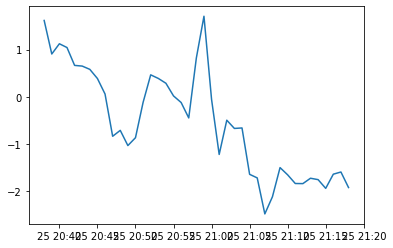

time
2020-04-25 20:19:00         NaN
2020-04-25 20:20:00         NaN
2020-04-25 20:21:00         NaN
2020-04-25 20:22:00         NaN
2020-04-25 20:23:00         NaN
2020-04-25 20:24:00         NaN
2020-04-25 20:25:00         NaN
2020-04-25 20:26:00         NaN
2020-04-25 20:27:00         NaN
2020-04-25 20:28:00         NaN
2020-04-25 20:29:00         NaN
2020-04-25 20:30:00         NaN
2020-04-25 20:31:00         NaN
2020-04-25 20:32:00         NaN
2020-04-25 20:33:00         NaN
2020-04-25 20:34:00         NaN
2020-04-25 20:35:00         NaN
2020-04-25 20:36:00         NaN
2020-04-25 20:37:00         NaN
2020-04-25 20:38:00    0.716077
2020-04-25 20:39:00    0.741730
2020-04-25 20:40:00    1.687919
2020-04-25 20:41:00    1.658072
2020-04-25 20:42:00    1.564372
2020-04-25 20:43:00    1.481474
2020-04-25 20:44:00    1.453360
2020-04-25 20:45:00    1.157516
2020-04-25 20:46:00    0.890484
2020-04-25 20:47:00   -0.073760
2020-04-25 20:48:00   -0.002444
2020-04-25 20:49:00    0.228876
202

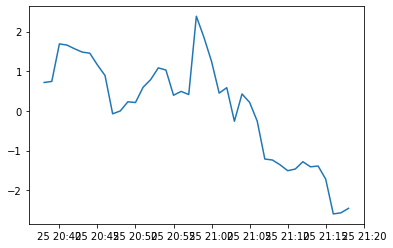

time
2020-04-25 20:19:00         NaN
2020-04-25 20:20:00         NaN
2020-04-25 20:21:00         NaN
2020-04-25 20:22:00         NaN
2020-04-25 20:23:00         NaN
2020-04-25 20:24:00         NaN
2020-04-25 20:25:00         NaN
2020-04-25 20:26:00         NaN
2020-04-25 20:27:00         NaN
2020-04-25 20:28:00         NaN
2020-04-25 20:29:00         NaN
2020-04-25 20:30:00         NaN
2020-04-25 20:31:00         NaN
2020-04-25 20:32:00         NaN
2020-04-25 20:33:00         NaN
2020-04-25 20:34:00         NaN
2020-04-25 20:35:00         NaN
2020-04-25 20:36:00         NaN
2020-04-25 20:37:00         NaN
2020-04-25 20:38:00    1.709037
2020-04-25 20:39:00    1.227676
2020-04-25 20:40:00    1.875303
2020-04-25 20:41:00    1.264871
2020-04-25 20:42:00    1.161365
2020-04-25 20:43:00    1.206902
2020-04-25 20:44:00    1.089079
2020-04-25 20:45:00    0.985289
2020-04-25 20:46:00    0.453369
2020-04-25 20:47:00   -0.490640
2020-04-25 20:48:00   -0.497045
2020-04-25 20:49:00   -0.471695
202

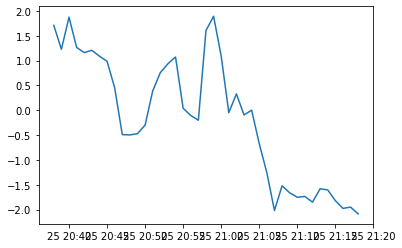

time
2020-04-25 20:19:00         NaN
2020-04-25 20:20:00         NaN
2020-04-25 20:21:00         NaN
2020-04-25 20:22:00         NaN
2020-04-25 20:23:00         NaN
2020-04-25 20:24:00         NaN
2020-04-25 20:25:00         NaN
2020-04-25 20:26:00         NaN
2020-04-25 20:27:00         NaN
2020-04-25 20:28:00         NaN
2020-04-25 20:29:00         NaN
2020-04-25 20:30:00         NaN
2020-04-25 20:31:00         NaN
2020-04-25 20:32:00         NaN
2020-04-25 20:33:00         NaN
2020-04-25 20:34:00         NaN
2020-04-25 20:35:00         NaN
2020-04-25 20:36:00         NaN
2020-04-25 20:37:00         NaN
2020-04-25 20:38:00    1.703325
2020-04-25 20:39:00    1.030609
2020-04-25 20:40:00    0.460029
2020-04-25 20:41:00    0.123288
2020-04-25 20:42:00    0.067756
2020-04-25 20:43:00   -0.403082
2020-04-25 20:44:00   -0.644348
2020-04-25 20:45:00   -0.523725
2020-04-25 20:46:00   -0.656875
2020-04-25 20:47:00   -0.544254
2020-04-25 20:48:00   -0.346633
2020-04-25 20:49:00   -0.859698
202

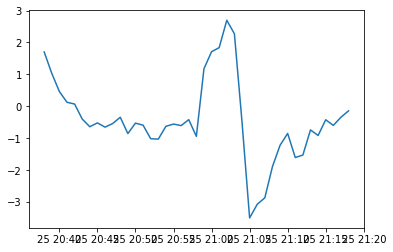

time
2020-04-25 20:20:00         NaN
2020-04-25 20:21:00         NaN
2020-04-25 20:22:00         NaN
2020-04-25 20:23:00         NaN
2020-04-25 20:24:00         NaN
2020-04-25 20:25:00         NaN
2020-04-25 20:26:00         NaN
2020-04-25 20:27:00         NaN
2020-04-25 20:28:00         NaN
2020-04-25 20:29:00         NaN
2020-04-25 20:30:00         NaN
2020-04-25 20:31:00         NaN
2020-04-25 20:32:00         NaN
2020-04-25 20:33:00         NaN
2020-04-25 20:34:00         NaN
2020-04-25 20:35:00         NaN
2020-04-25 20:36:00         NaN
2020-04-25 20:37:00         NaN
2020-04-25 20:38:00         NaN
2020-04-25 20:39:00   -0.650092
2020-04-25 20:40:00   -0.754274
2020-04-25 20:41:00   -0.733654
2020-04-25 20:42:00   -0.662695
2020-04-25 20:43:00   -0.614465
2020-04-25 20:44:00   -0.543496
2020-04-25 20:45:00   -0.540297
2020-04-25 20:46:00   -0.537110
2020-04-25 20:47:00   -0.533936
2020-04-25 20:48:00   -0.464286
2020-04-25 20:49:00   -0.972716
2020-04-25 20:50:00   -1.815162
202

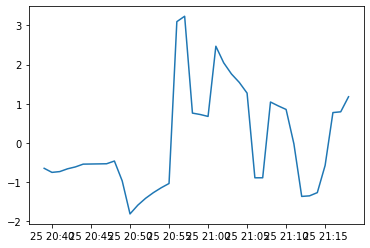

time
2020-04-25 20:20:00         NaN
2020-04-25 20:21:00         NaN
2020-04-25 20:22:00         NaN
2020-04-25 20:23:00         NaN
2020-04-25 20:24:00         NaN
2020-04-25 20:25:00         NaN
2020-04-25 20:26:00         NaN
2020-04-25 20:27:00         NaN
2020-04-25 20:28:00         NaN
2020-04-25 20:29:00         NaN
2020-04-25 20:30:00         NaN
2020-04-25 20:31:00         NaN
2020-04-25 20:32:00         NaN
2020-04-25 20:33:00         NaN
2020-04-25 20:34:00         NaN
2020-04-25 20:35:00         NaN
2020-04-25 20:36:00         NaN
2020-04-25 20:37:00         NaN
2020-04-25 20:38:00         NaN
2020-04-25 20:39:00    0.728742
2020-04-25 20:40:00    1.045684
2020-04-25 20:41:00    1.075680
2020-04-25 20:42:00    0.741077
2020-04-25 20:43:00    0.776183
2020-04-25 20:44:00    0.638096
2020-04-25 20:45:00    0.335374
2020-04-25 20:46:00    0.320367
2020-04-25 20:47:00   -0.111323
2020-04-25 20:48:00   -0.110336
2020-04-25 20:49:00   -0.663569
2020-04-25 20:50:00   -0.496668
202

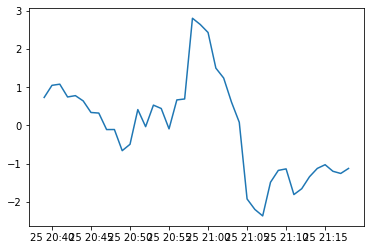

In [8]:
for symbol in symbols.keys():
    print(symbols[symbol].CCI)
    plt.plot(symbols[symbol].CCI)
    plt.show()

time
2020-04-25 20:19:00     True
2020-04-25 20:34:00     True
2020-04-25 20:35:00     True
2020-04-25 21:07:00    False
2020-04-25 21:11:00    False
2020-04-25 21:18:00    False
Name: uptrend, dtype: bool


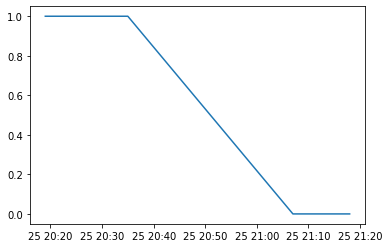

time
2020-04-25 20:19:00     True
2020-04-25 20:30:00    False
2020-04-25 20:40:00     True
2020-04-25 20:58:00     True
2020-04-25 21:15:00    False
2020-04-25 21:16:00    False
2020-04-25 21:18:00    False
Name: uptrend, dtype: bool


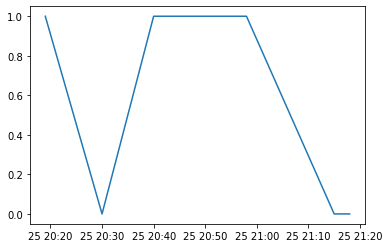

time
2020-04-25 20:19:00     True
2020-04-25 20:35:00     True
2020-04-25 20:40:00     True
2020-04-25 21:11:00    False
2020-04-25 21:15:00    False
2020-04-25 21:16:00    False
2020-04-25 21:18:00    False
Name: uptrend, dtype: bool


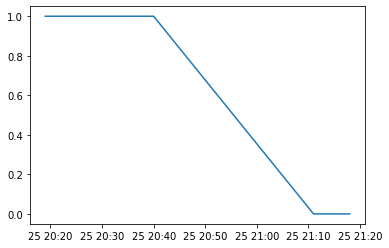

time
2020-04-25 20:19:00     True
2020-04-25 20:25:00     True
2020-04-25 20:34:00     True
2020-04-25 20:34:00     True
2020-04-25 20:36:00     True
2020-04-25 20:43:00    False
2020-04-25 20:52:00    False
2020-04-25 21:05:00    False
2020-04-25 21:05:00    False
2020-04-25 21:07:00    False
2020-04-25 21:18:00     True
Name: uptrend, dtype: bool


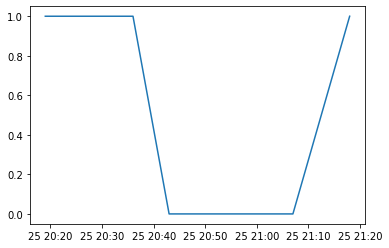

time
2020-04-25 20:20:00     True
2020-04-25 20:24:00     True
2020-04-25 20:25:00    False
2020-04-25 20:25:00    False
2020-04-25 20:28:00     True
2020-04-25 20:28:00     True
2020-04-25 20:31:00    False
2020-04-25 20:31:00    False
2020-04-25 20:40:00    False
2020-04-25 20:56:00     True
2020-04-25 20:56:00     True
2020-04-25 20:57:00     True
2020-04-25 20:58:00    False
2020-04-25 21:01:00     True
2020-04-25 21:06:00    False
2020-04-25 21:06:00    False
2020-04-25 21:06:00    False
2020-04-25 21:08:00     True
2020-04-25 21:08:00     True
2020-04-25 21:12:00    False
2020-04-25 21:12:00    False
2020-04-25 21:16:00     True
2020-04-25 21:16:00     True
2020-04-25 21:18:00     True
2020-04-25 21:18:00     True
Name: uptrend, dtype: bool


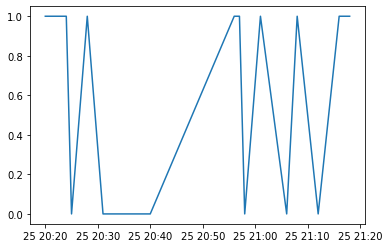

time
2020-04-25 20:20:00     True
2020-04-25 20:31:00    False
2020-04-25 20:35:00     True
2020-04-25 20:36:00     True
2020-04-25 21:05:00    False
2020-04-25 21:05:00    False
2020-04-25 21:11:00    False
Name: uptrend, dtype: bool


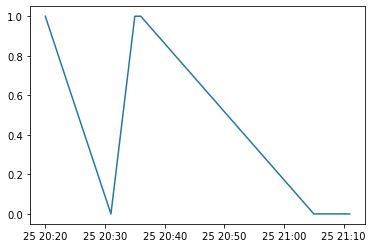

In [9]:
for symbol in symbols.keys():
    print(symbols[symbol].renko)
    plt.plot(symbols[symbol].renko)
    plt.show()

time
2020-04-25 20:45:00    0.214846
2020-04-25 20:46:00    0.246533
2020-04-25 20:47:00    0.272970
2020-04-25 20:48:00    0.295150
2020-04-25 20:49:00    0.335953
2020-04-25 20:50:00    0.311958
2020-04-25 20:51:00    0.280064
2020-04-25 20:52:00    0.252900
2020-04-25 20:53:00    0.229707
2020-04-25 20:54:00    0.247814
2020-04-25 20:55:00    0.263334
2020-04-25 20:56:00    0.294178
2020-04-25 20:57:00    0.276634
2020-04-25 20:58:00    0.243752
2020-04-25 20:59:00    0.242936
2020-04-25 21:00:00    0.259644
2020-04-25 21:01:00    0.257684
2020-04-25 21:02:00    0.255992
2020-04-25 21:03:00    0.261948
2020-04-25 21:04:00    0.292958
2020-04-25 21:05:00    0.319763
2020-04-25 21:06:00    0.365276
2020-04-25 21:07:00    0.404644
2020-04-25 21:08:00    0.410475
2020-04-25 21:09:00    0.420566
2020-04-25 21:10:00    0.447309
2020-04-25 21:11:00    0.476471
2020-04-25 21:12:00    0.501720
2020-04-25 21:13:00    0.530945
2020-04-25 21:14:00    0.564100
2020-04-25 21:15:00    0.592817
202

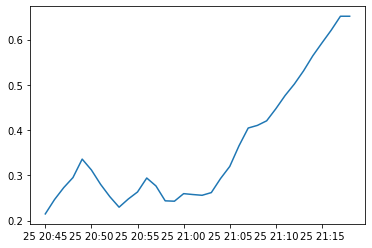

time
2020-04-25 20:45:00    0.475280
2020-04-25 20:46:00    0.443379
2020-04-25 20:47:00    0.416765
2020-04-25 20:48:00    0.394435
2020-04-25 20:49:00    0.375075
2020-04-25 20:50:00    0.340083
2020-04-25 20:51:00    0.310531
2020-04-25 20:52:00    0.306364
2020-04-25 20:53:00    0.302806
2020-04-25 20:54:00    0.265272
2020-04-25 20:55:00    0.239757
2020-04-25 20:56:00    0.215315
2020-04-25 20:57:00    0.264219
2020-04-25 20:58:00    0.306301
2020-04-25 20:59:00    0.317277
2020-04-25 21:00:00    0.288159
2020-04-25 21:01:00    0.263040
2020-04-25 21:02:00    0.250541
2020-04-25 21:03:00    0.219177
2020-04-25 21:04:00    0.192076
2020-04-25 21:05:00    0.190966
2020-04-25 21:06:00    0.208271
2020-04-25 21:07:00    0.218105
2020-04-25 21:08:00    0.226614
2020-04-25 21:09:00    0.233978
2020-04-25 21:10:00    0.241537
2020-04-25 21:11:00    0.223952
2020-04-25 21:12:00    0.211993
2020-04-25 21:13:00    0.220294
2020-04-25 21:14:00    0.242092
2020-04-25 21:15:00    0.306673
202

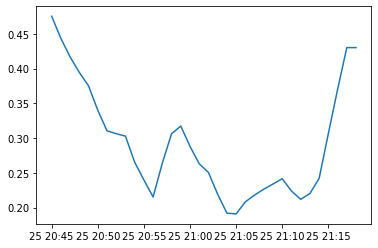

time
2020-04-25 20:45:00    0.323972
2020-04-25 20:46:00    0.335242
2020-04-25 20:47:00    0.344644
2020-04-25 20:48:00    0.340830
2020-04-25 20:49:00    0.315414
2020-04-25 20:50:00    0.297482
2020-04-25 20:51:00    0.288126
2020-04-25 20:52:00    0.298652
2020-04-25 20:53:00    0.307639
2020-04-25 20:54:00    0.273926
2020-04-25 20:55:00    0.245031
2020-04-25 20:56:00    0.247383
2020-04-25 20:57:00    0.238409
2020-04-25 20:58:00    0.230687
2020-04-25 20:59:00    0.207546
2020-04-25 21:00:00    0.211928
2020-04-25 21:01:00    0.206199
2020-04-25 21:02:00    0.214225
2020-04-25 21:03:00    0.221158
2020-04-25 21:04:00    0.242204
2020-04-25 21:05:00    0.268034
2020-04-25 21:06:00    0.311870
2020-04-25 21:07:00    0.340859
2020-04-25 21:08:00    0.365941
2020-04-25 21:09:00    0.395359
2020-04-25 21:10:00    0.374198
2020-04-25 21:11:00    0.367357
2020-04-25 21:12:00    0.361434
2020-04-25 21:13:00    0.363764
2020-04-25 21:14:00    0.379050
2020-04-25 21:15:00    0.407396
202

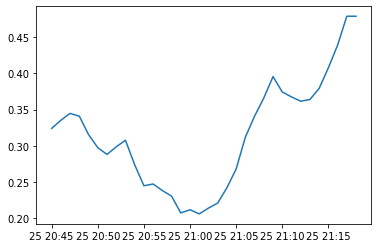

time
2020-04-25 20:45:00    0.385345
2020-04-25 20:46:00    0.331221
2020-04-25 20:47:00    0.313523
2020-04-25 20:48:00    0.298673
2020-04-25 20:49:00    0.316963
2020-04-25 20:50:00    0.332443
2020-04-25 20:51:00    0.306519
2020-04-25 20:52:00    0.284439
2020-04-25 20:53:00    0.265587
2020-04-25 20:54:00    0.249459
2020-04-25 20:55:00    0.235635
2020-04-25 20:56:00    0.223768
2020-04-25 20:57:00    0.202042
2020-04-25 20:58:00    0.209278
2020-04-25 20:59:00    0.215510
2020-04-25 21:00:00    0.249713
2020-04-25 21:01:00    0.289398
2020-04-25 21:02:00    0.323655
2020-04-25 21:03:00    0.317183
2020-04-25 21:04:00    0.360809
2020-04-25 21:05:00    0.399885
2020-04-25 21:06:00    0.443365
2020-04-25 21:07:00    0.436369
2020-04-25 21:08:00    0.415952
2020-04-25 21:09:00    0.398282
2020-04-25 21:10:00    0.418215
2020-04-25 21:11:00    0.435472
2020-04-25 21:12:00    0.407840
2020-04-25 21:13:00    0.383912
2020-04-25 21:14:00    0.363188
2020-04-25 21:15:00    0.345239
202

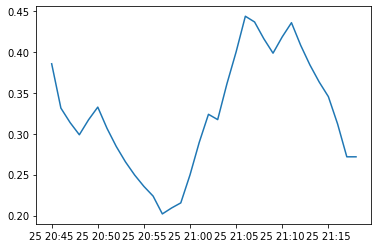

time
2020-04-25 20:46:00    0.259191
2020-04-25 20:47:00    0.259919
2020-04-25 20:48:00    0.236957
2020-04-25 20:49:00    0.217692
2020-04-25 20:50:00    0.201450
2020-04-25 20:51:00    0.187704
2020-04-25 20:52:00    0.176029
2020-04-25 20:53:00    0.166086
2020-04-25 20:54:00    0.157597
2020-04-25 20:55:00    0.249728
2020-04-25 20:56:00    0.329510
2020-04-25 20:57:00    0.296017
2020-04-25 20:58:00    0.267228
2020-04-25 20:59:00    0.242455
2020-04-25 21:00:00    0.270091
2020-04-25 21:01:00    0.293916
2020-04-25 21:02:00    0.314469
2020-04-25 21:03:00    0.332210
2020-04-25 21:04:00    0.319232
2020-04-25 21:05:00    0.323892
2020-04-25 21:06:00    0.327920
2020-04-25 21:07:00    0.309587
2020-04-25 21:08:00    0.293728
2020-04-25 21:09:00    0.280007
2020-04-25 21:10:00    0.279987
2020-04-25 21:11:00    0.279970
2020-04-25 21:12:00    0.279956
2020-04-25 21:13:00    0.276244
2020-04-25 21:14:00    0.271836
2020-04-25 21:15:00    0.268019
2020-04-25 21:16:00    0.264712
202

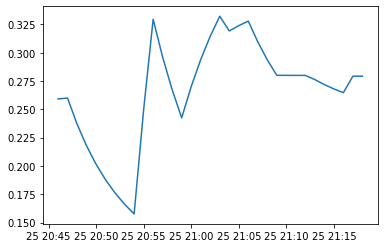

time
2020-04-25 20:46:00    0.334220
2020-04-25 20:47:00    0.348950
2020-04-25 20:48:00    0.380357
2020-04-25 20:49:00    0.406708
2020-04-25 20:50:00    0.360252
2020-04-25 20:51:00    0.320931
2020-04-25 20:52:00    0.276173
2020-04-25 20:53:00    0.238052
2020-04-25 20:54:00    0.226296
2020-04-25 20:55:00    0.215244
2020-04-25 20:56:00    0.205771
2020-04-25 20:57:00    0.239004
2020-04-25 20:58:00    0.267915
2020-04-25 20:59:00    0.300269
2020-04-25 21:00:00    0.277477
2020-04-25 21:01:00    0.257828
2020-04-25 21:02:00    0.250606
2020-04-25 21:03:00    0.254353
2020-04-25 21:04:00    0.305463
2020-04-25 21:05:00    0.352419
2020-04-25 21:06:00    0.399738
2020-04-25 21:07:00    0.410879
2020-04-25 21:08:00    0.420516
2020-04-25 21:09:00    0.428854
2020-04-25 21:10:00    0.463771
2020-04-25 21:11:00    0.493995
2020-04-25 21:12:00    0.506837
2020-04-25 21:13:00    0.517957
2020-04-25 21:14:00    0.527587
2020-04-25 21:15:00    0.550359
2020-04-25 21:16:00    0.570237
202

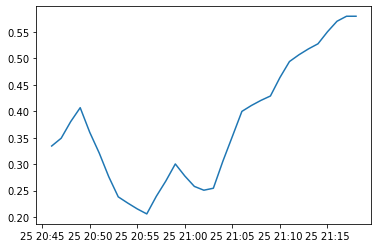

In [10]:
for symbol in symbols.keys():
    print(symbols[symbol].ADX)
    plt.plot(symbols[symbol].ADX)
    plt.show()

                             K          D           J
time                                                 
2020-04-25 20:19:00  42.424242  47.474747   32.323232
2020-04-25 20:20:00  44.949495  46.632997   41.582492
2020-04-25 20:21:00  43.546577  45.604190   39.431351
2020-04-25 20:22:00  41.376730  44.195037   35.740117
2020-04-25 20:23:00  54.744981  47.711685   68.811573
2020-04-25 20:24:00  59.953444  51.792271   76.275789
2020-04-25 20:25:00  52.314642  51.966395   53.011136
2020-04-25 20:26:00  50.352618  51.428469   48.200916
2020-04-25 20:27:00  58.568412  53.808450   68.088336
2020-04-25 20:28:00  63.490053  57.035651   76.398856
2020-04-25 20:29:00  71.358960  61.810087   90.456705
2020-04-25 20:30:00  56.768042  60.129406   50.045315
2020-04-25 20:31:00  54.512028  58.256946   47.022192
2020-04-25 20:32:00  58.136224  58.216706   57.975260
2020-04-25 20:33:00  60.552354  58.995255   63.666553
2020-04-25 20:34:00  66.125812  61.372107   75.633221
2020-04-25 20:35:00  73.6293

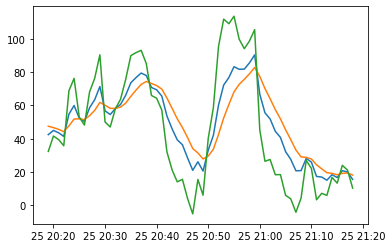

                             K          D          J
time                                                
2020-04-25 20:19:00  42.982456  47.660819  33.625731
2020-04-25 20:20:00  42.375989  45.899209  35.329550
2020-04-25 20:21:00  35.230876  42.343098  21.006432
2020-04-25 20:22:00  27.369296  37.351831   7.404227
2020-04-25 20:23:00  23.350998  32.684887   4.683221
2020-04-25 20:24:00  23.426193  29.598655  11.081269
2020-04-25 20:25:00  33.019893  30.739068  37.581544
2020-04-25 20:26:00  32.079374  31.185837  33.866450
2020-04-25 20:27:00  37.082560  33.151411  44.944858
2020-04-25 20:28:00  31.207005  32.503276  28.614463
2020-04-25 20:29:00  25.828367  30.278306  16.928488
2020-04-25 20:30:00  21.479563  27.345392   9.747905
2020-04-25 20:31:00  22.955572  25.882118  17.102479
2020-04-25 20:32:00  26.552340  26.105525  27.445968
2020-04-25 20:33:00  30.517841  27.576297  36.400929
2020-04-25 20:34:00  29.943687  28.365427  33.100207
2020-04-25 20:35:00  49.366252  35.365702  77.

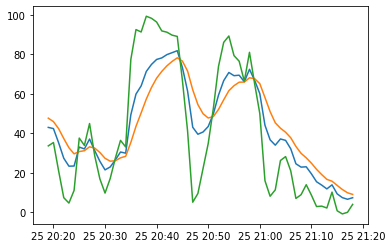

                             K          D           J
time                                                 
2020-04-25 20:19:00  40.000000  46.666667   26.666667
2020-04-25 20:20:00  37.777778  43.703704   25.925926
2020-04-25 20:21:00  26.260454  37.889287    3.002788
2020-04-25 20:22:00  24.369714  33.382763    6.343617
2020-04-25 20:23:00  28.991574  31.919033   23.136656
2020-04-25 20:24:00  20.253642  28.030570    4.699787
2020-04-25 20:25:00  30.926671  28.995937   34.788138
2020-04-25 20:26:00  29.708689  29.233521   30.659027
2020-04-25 20:27:00  34.957308  31.141450   42.589024
2020-04-25 20:28:00  35.270684  32.517861   40.776329
2020-04-25 20:29:00  35.479601  33.505108   39.428588
2020-04-25 20:30:00  26.217170  31.075795   16.499920
2020-04-25 20:31:00  18.291122  26.814237    1.244890
2020-04-25 20:32:00  26.638525  26.755667   26.404243
2020-04-25 20:33:00  36.647906  30.053080   49.837558
2020-04-25 20:34:00  54.061567  38.055909   86.072883
2020-04-25 20:35:00  67.8592

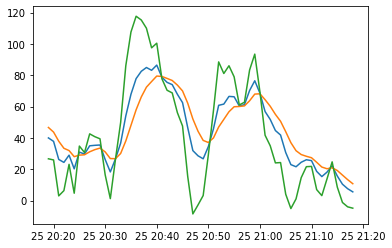

                             K          D           J
time                                                 
2020-04-25 20:19:00  33.333333  44.444444   11.111111
2020-04-25 20:20:00  25.925926  38.271605    1.234568
2020-04-25 20:21:00  17.283951  31.275720  -10.699588
2020-04-25 20:22:00  18.189300  26.913580    0.740741
2020-04-25 20:23:00  15.459534  23.095565    0.187471
2020-04-25 20:24:00  13.639689  19.943606    1.031855
2020-04-25 20:25:00  32.426459  24.104557   49.070264
2020-04-25 20:26:00  48.284306  32.164474   80.523972
2020-04-25 20:27:00  32.189538  32.172828   32.222956
2020-04-25 20:28:00  44.793025  36.379560   61.619954
2020-04-25 20:29:00  33.195350  35.318157   28.949736
2020-04-25 20:30:00  25.463567  32.033294   12.324113
2020-04-25 20:31:00  43.642378  35.902988   59.121157
2020-04-25 20:32:00  49.094919  40.300298   66.684159
2020-04-25 20:33:00  52.729946  44.443514   69.302809
2020-04-25 20:34:00  66.732244  51.873091   96.450552
2020-04-25 20:35:00  77.8214

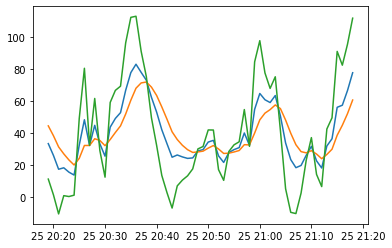

                             K          D           J
time                                                 
2020-04-25 20:20:00  33.333333  44.444444   11.111111
2020-04-25 20:21:00  55.555556  48.148148   70.370370
2020-04-25 20:22:00  37.037037  44.444444   22.222222
2020-04-25 20:23:00  24.691358  37.860082   -1.646091
2020-04-25 20:24:00  49.382716  41.700960   64.746228
2020-04-25 20:25:00  32.921811  38.774577   21.216278
2020-04-25 20:26:00  21.947874  33.165676   -0.487731
2020-04-25 20:27:00  14.631916  26.987756  -10.079764
2020-04-25 20:28:00  42.233243  32.069585   62.560559
2020-04-25 20:29:00  59.779427  41.306199   96.725883
2020-04-25 20:30:00  71.476883  51.363094  111.704462
2020-04-25 20:31:00  48.513324  50.413171   44.713632
2020-04-25 20:32:00  33.204285  44.676875   10.259105
2020-04-25 20:33:00  23.013383  37.455711   -5.871273
2020-04-25 20:34:00  16.511846  30.474423  -11.413308
2020-04-25 20:35:00  12.177488  24.375445  -12.218425
2020-04-25 20:36:00   8.4186

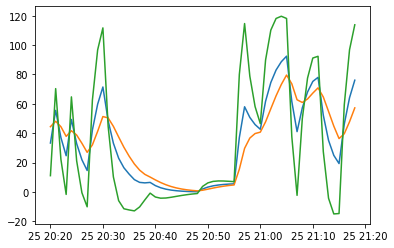

                             K          D           J
time                                                 
2020-04-25 20:20:00  54.794521  51.598174   61.187215
2020-04-25 20:21:00  40.401734  47.866027   25.473149
2020-04-25 20:22:00  32.826745  42.852933   12.774370
2020-04-25 20:23:00  24.073049  36.592972   -0.966796
2020-04-25 20:24:00  21.197751  31.461232    0.670790
2020-04-25 20:25:00  22.435511  28.452658   10.401218
2020-04-25 20:26:00  19.939214  25.614843    8.587955
2020-04-25 20:27:00  27.171813  26.133833   29.247772
2020-04-25 20:28:00  21.436013  24.567893   15.172252
2020-04-25 20:29:00  15.970262  21.702016    4.506753
2020-04-25 20:30:00  13.332465  18.912166    2.173064
2020-04-25 20:31:00   8.888310  15.570881   -4.476831
2020-04-25 20:32:00  24.004636  18.382132   35.249644
2020-04-25 20:33:00  41.493287  26.085851   72.308159
2020-04-25 20:34:00  48.477330  33.549677   78.332635
2020-04-25 20:35:00  65.651553  44.250302  108.454055
2020-04-25 20:36:00  73.9581

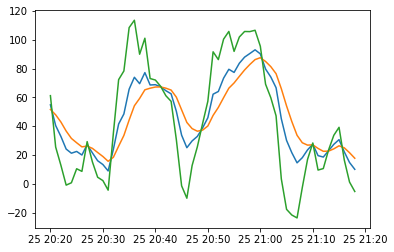

In [11]:
for symbol in symbols.keys():
    print(symbols[symbol].KDJ)
    plt.plot(symbols[symbol].KDJ)
    plt.show()

                             MACD   signal_line     histogram
time                                                         
2020-04-25 20:19:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 20:20:00  2.243590e-08  1.246439e-08  9.971510e-09
2020-04-25 20:21:00 -2.505017e-07 -9.530859e-08 -1.551931e-07
2020-04-25 20:22:00 -4.046045e-07 -2.000836e-07 -2.045209e-07
2020-04-25 20:23:00 -2.316098e-09 -1.412523e-07  1.389362e-07
2020-04-25 20:24:00  1.112756e-07 -7.280318e-08  1.840787e-07
2020-04-25 20:25:00 -2.255088e-07 -1.114489e-07 -1.140599e-07
2020-04-25 20:26:00 -3.050278e-07 -1.579696e-07 -1.470583e-07
2020-04-25 20:27:00  4.145702e-08 -1.119010e-07  1.533581e-07
2020-04-25 20:28:00  3.381503e-07 -1.106341e-08  3.492137e-07
2020-04-25 20:29:00  8.141811e-07  1.694954e-07  6.446857e-07
2020-04-25 20:30:00  2.182799e-07  1.799723e-07  3.830770e-08
2020-04-25 20:31:00  2.253533e-07  1.895765e-07  3.577684e-08
2020-04-25 20:32:00  4.595456e-07  2.460542e-07  2.134914e-07
2020-04-

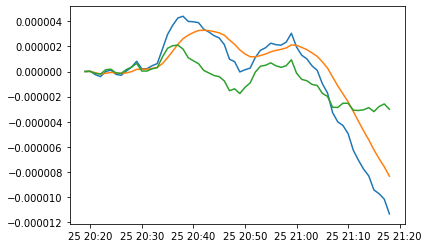

                         MACD  signal_line  histogram
time                                                 
2020-04-25 20:19:00  0.000000     0.000000   0.000000
2020-04-25 20:20:00 -0.018846    -0.010470  -0.008376
2020-04-25 20:21:00 -0.082933    -0.040168  -0.042765
2020-04-25 20:22:00 -0.140015    -0.073991  -0.066023
2020-04-25 20:23:00 -0.186389    -0.107427  -0.078962
2020-04-25 20:24:00 -0.261220    -0.149114  -0.112107
2020-04-25 20:25:00 -0.211390    -0.164874  -0.046516
2020-04-25 20:26:00 -0.338183    -0.206524  -0.131660
2020-04-25 20:27:00 -0.289860    -0.225775  -0.064085
2020-04-25 20:28:00 -0.508910    -0.289213  -0.219697
2020-04-25 20:29:00 -0.701085    -0.379329  -0.321756
2020-04-25 20:30:00 -0.891215    -0.489260  -0.401955
2020-04-25 20:31:00 -1.003453    -0.598081  -0.405371
2020-04-25 20:32:00 -1.019373    -0.686216  -0.333157
2020-04-25 20:33:00 -0.984548    -0.748058  -0.236490
2020-04-25 20:34:00 -1.016708    -0.803344  -0.213364
2020-04-25 20:35:00 -0.57314

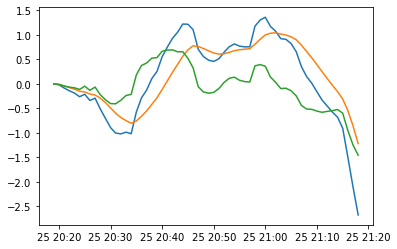

                         MACD  signal_line  histogram
time                                                 
2020-04-25 20:19:00  0.000000     0.000000   0.000000
2020-04-25 20:20:00 -0.000897    -0.000499  -0.000399
2020-04-25 20:21:00 -0.005485    -0.002542  -0.002943
2020-04-25 20:22:00 -0.006354    -0.003833  -0.002520
2020-04-25 20:23:00 -0.004305    -0.003974  -0.000331
2020-04-25 20:24:00 -0.008978    -0.005330  -0.003648
2020-04-25 20:25:00 -0.005479    -0.005368  -0.000111
2020-04-25 20:26:00 -0.008276    -0.006067  -0.002209
2020-04-25 20:27:00 -0.006118    -0.006078  -0.000039
2020-04-25 20:28:00 -0.007588    -0.006417  -0.001171
2020-04-25 20:29:00 -0.008544    -0.006882  -0.001662
2020-04-25 20:30:00 -0.015172    -0.008662  -0.006509
2020-04-25 20:31:00 -0.022145    -0.011516  -0.010629
2020-04-25 20:32:00 -0.020122    -0.013316  -0.006806
2020-04-25 20:33:00 -0.015966    -0.013866  -0.002101
2020-04-25 20:34:00 -0.003515    -0.011735   0.008221
2020-04-25 20:35:00  0.01221

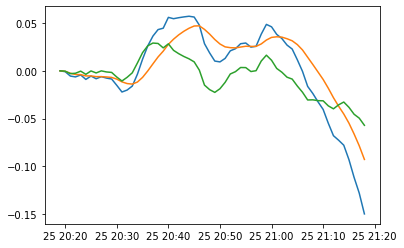

                             MACD   signal_line     histogram
time                                                         
2020-04-25 20:19:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 20:20:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 20:21:00 -6.201988e-09 -2.541798e-09 -3.660190e-09
2020-04-25 20:22:00 -1.649855e-09 -2.239650e-09  5.897946e-10
2020-04-25 20:23:00 -3.120790e-09 -2.501769e-09 -6.190215e-10
2020-04-25 20:24:00 -3.946362e-09 -2.893334e-09 -1.053028e-09
2020-04-25 20:25:00  2.277318e-08  3.602175e-09  1.917100e-08
2020-04-25 20:26:00  4.507927e-08  1.356990e-08  3.150937e-08
2020-04-25 20:27:00  2.014900e-08  1.508971e-08  5.059297e-09
2020-04-25 20:28:00  3.822754e-08  2.027392e-08  1.795361e-08
2020-04-25 20:29:00  1.878992e-08  1.994923e-08 -1.159311e-09
2020-04-25 20:30:00  4.283600e-09  1.658491e-08 -1.230131e-08
2020-04-25 20:31:00  3.301022e-08  2.006108e-08  1.294914e-08
2020-04-25 20:32:00  4.249250e-08  2.475375e-08  1.773876e-08
2020-04-

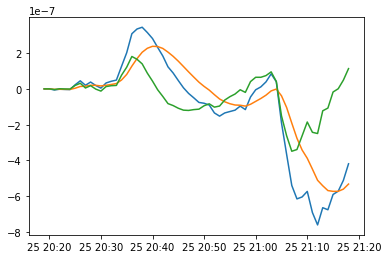

                             MACD   signal_line     histogram
time                                                         
2020-04-25 20:20:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 20:21:00  2.243590e-08  1.246439e-08  9.971510e-09
2020-04-25 20:22:00 -1.149790e-06 -4.638694e-07 -6.859206e-07
2020-04-25 20:23:00 -1.654763e-06 -8.672885e-07 -7.874743e-07
2020-04-25 20:24:00  1.289064e-06 -2.258225e-07  1.514886e-06
2020-04-25 20:25:00 -1.925756e-06 -6.865989e-07 -1.239157e-06
2020-04-25 20:26:00 -3.954280e-06 -1.513562e-06 -2.440718e-06
2020-04-25 20:27:00 -5.250888e-06 -2.411712e-06 -2.839177e-06
2020-04-25 20:28:00 -4.129157e-07 -1.949980e-06  1.537064e-06
2020-04-25 20:29:00  2.870492e-06 -8.699144e-07  3.740406e-06
2020-04-25 20:30:00  5.202878e-06  4.587778e-07  4.744100e-06
2020-04-25 20:31:00  9.095383e-07  5.555822e-07  3.539561e-07
2020-04-25 20:32:00 -2.286584e-06 -4.591884e-08 -2.240665e-06
2020-04-25 20:33:00 -4.649226e-06 -1.008934e-06 -3.640292e-06
2020-04-

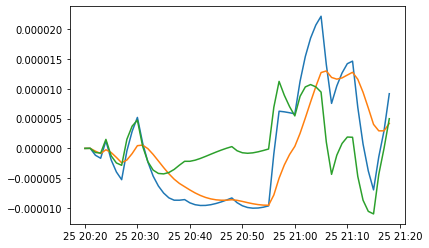

                         MACD  signal_line  histogram
time                                                 
2020-04-25 20:20:00  0.000000     0.000000   0.000000
2020-04-25 20:21:00 -0.000334    -0.000186  -0.000149
2020-04-25 20:22:00 -0.000389    -0.000269  -0.000120
2020-04-25 20:23:00 -0.000483    -0.000342  -0.000142
2020-04-25 20:24:00 -0.000616    -0.000423  -0.000193
2020-04-25 20:25:00 -0.000697    -0.000498  -0.000200
2020-04-25 20:26:00 -0.000864    -0.000590  -0.000274
2020-04-25 20:27:00 -0.000605    -0.000594  -0.000011
2020-04-25 20:28:00 -0.000859    -0.000655  -0.000203
2020-04-25 20:29:00 -0.001170    -0.000770  -0.000399
2020-04-25 20:30:00 -0.001357    -0.000899  -0.000458
2020-04-25 20:31:00 -0.001569    -0.001043  -0.000527
2020-04-25 20:32:00 -0.001164    -0.001068  -0.000095
2020-04-25 20:33:00 -0.000648    -0.000980   0.000333
2020-04-25 20:34:00 -0.000173    -0.000813   0.000640
2020-04-25 20:35:00  0.001038    -0.000432   0.001470
2020-04-25 20:36:00  0.00215

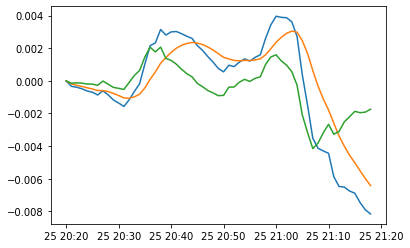

In [12]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD)
    plt.plot(symbols[symbol].MACD)
    plt.show()

                         open      high       low     close   volume  \
time                                                                   
2020-04-25 20:57:00  0.025712  0.025726  0.025711  0.025726   79.719   
2020-04-25 20:58:00  0.025721  0.025732  0.025720  0.025730  197.901   
2020-04-25 20:59:00  0.025730  0.025737  0.025725  0.025737   61.707   
2020-04-25 21:00:00  0.025730  0.025737  0.025716  0.025716  126.304   
2020-04-25 21:01:00  0.025715  0.025719  0.025710  0.025719   69.328   
2020-04-25 21:02:00  0.025720  0.025722  0.025715  0.025722   22.352   
2020-04-25 21:03:00  0.025721  0.025722  0.025715  0.025718   40.101   
2020-04-25 21:04:00  0.025718  0.025722  0.025713  0.025719   22.151   
2020-04-25 21:05:00  0.025716  0.025721  0.025704  0.025709   98.477   
2020-04-25 21:06:00  0.025709  0.025712  0.025706  0.025710   36.672   
2020-04-25 21:07:00  0.025710  0.025711  0.025694  0.025697   91.591   
2020-04-25 21:08:00  0.025697  0.025704  0.025694  0.025703   54

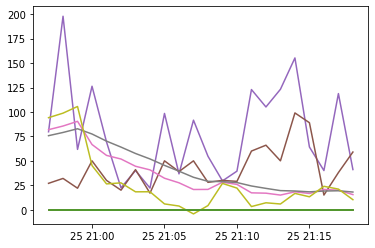

                        open     high      low    close     volume  \
time                                                                 
2020-04-25 20:57:00  7551.59  7552.95  7550.97  7551.91   6.144310   
2020-04-25 20:58:00  7551.91  7559.01  7551.90  7557.51  54.057376   
2020-04-25 20:59:00  7557.52  7557.52  7554.48  7555.00   9.871547   
2020-04-25 21:00:00  7555.94  7556.00  7553.36  7554.68   8.961532   
2020-04-25 21:01:00  7554.68  7555.99  7551.24  7551.87  10.205718   
2020-04-25 21:02:00  7551.86  7555.91  7551.56  7552.67   5.343978   
2020-04-25 21:03:00  7552.30  7553.65  7549.01  7551.87  12.434499   
2020-04-25 21:04:00  7551.82  7554.99  7550.59  7553.35  10.539330   
2020-04-25 21:05:00  7553.46  7553.50  7551.57  7552.51   6.655535   
2020-04-25 21:06:00  7552.91  7553.14  7550.00  7551.37   9.173077   
2020-04-25 21:07:00  7551.29  7551.58  7548.39  7549.25   9.159317   
2020-04-25 21:08:00  7549.06  7551.83  7548.25  7549.76  10.300012   
2020-04-25 21:09:00 

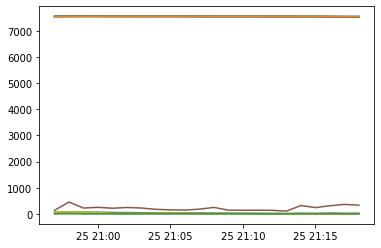

                       open    high     low   close      volume  \
time                                                              
2020-04-25 20:57:00  194.20  194.27  194.11  194.26    68.77032   
2020-04-25 20:58:00  194.22  194.47  194.22  194.42   272.92313   
2020-04-25 20:59:00  194.42  194.43  194.41  194.43    82.83334   
2020-04-25 21:00:00  194.42  194.45  194.30  194.30   147.02002   
2020-04-25 21:01:00  194.30  194.30  194.19  194.23    80.48784   
2020-04-25 21:02:00  194.25  194.33  194.24  194.26    24.65956   
2020-04-25 21:03:00  194.27  194.30  194.18  194.22   182.34582   
2020-04-25 21:04:00  194.21  194.30  194.18  194.24    53.55246   
2020-04-25 21:05:00  194.26  194.26  194.11  194.14   469.47926   
2020-04-25 21:06:00  194.14  194.14  194.07  194.10    50.13718   
2020-04-25 21:07:00  194.09  194.10  193.92  194.02  1234.94501   
2020-04-25 21:08:00  194.00  194.12  193.99  194.08   239.95126   
2020-04-25 21:09:00  194.04  194.06  194.02  194.04    18.3111

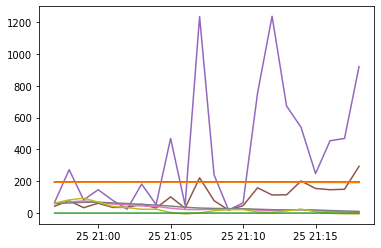

                         open      high       low     close   volume  \
time                                                                   
2020-04-25 20:57:00  0.002144  0.002144  0.002143  0.002144   431.62   
2020-04-25 20:58:00  0.002144  0.002144  0.002143  0.002143   392.85   
2020-04-25 20:59:00  0.002143  0.002144  0.002143  0.002144   565.11   
2020-04-25 21:00:00  0.002144  0.002144  0.002144  0.002144   222.85   
2020-04-25 21:01:00  0.002144  0.002145  0.002144  0.002144  3369.54   
2020-04-25 21:02:00  0.002144  0.002145  0.002144  0.002144   368.45   
2020-04-25 21:03:00  0.002144  0.002145  0.002144  0.002145   341.88   
2020-04-25 21:04:00  0.002144  0.002145  0.002143  0.002144  1060.83   
2020-04-25 21:05:00  0.002143  0.002144  0.002141  0.002141   458.75   
2020-04-25 21:06:00  0.002141  0.002142  0.002141  0.002141   205.63   
2020-04-25 21:07:00  0.002141  0.002141  0.002140  0.002141   893.68   
2020-04-25 21:08:00  0.002142  0.002142  0.002141  0.002141   29

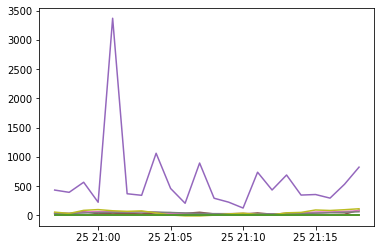

                         open      high       low     close  volume  \
time                                                                  
2020-04-25 20:58:00  0.083304  0.083304  0.083304  0.083304    2.67   
2020-04-25 20:59:00  0.083304  0.083304  0.083304  0.083304    1.00   
2020-04-25 21:00:00  0.083304  0.083304  0.083304  0.083304    0.00   
2020-04-25 21:01:00  0.083378  0.083378  0.083378  0.083378    0.74   
2020-04-25 21:02:00  0.083378  0.083378  0.083378  0.083378    0.23   
2020-04-25 21:03:00  0.083378  0.083378  0.083378  0.083378    0.00   
2020-04-25 21:04:00  0.083378  0.083378  0.083378  0.083378    0.00   
2020-04-25 21:05:00  0.083360  0.083378  0.083360  0.083378    0.49   
2020-04-25 21:06:00  0.083266  0.083266  0.083262  0.083262    6.95   
2020-04-25 21:07:00  0.083262  0.083262  0.083262  0.083262   12.01   
2020-04-25 21:08:00  0.083366  0.083366  0.083366  0.083366   23.45   
2020-04-25 21:09:00  0.083366  0.083366  0.083366  0.083366    0.00   
2020-0

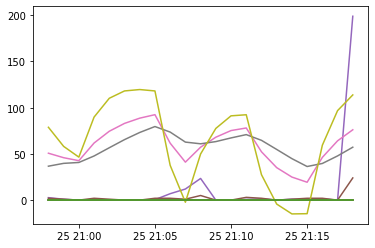

                        open     high      low    close   volume  \
time                                                               
2020-04-25 20:58:00  16.1848  16.2000  16.1847  16.1988   474.45   
2020-04-25 20:59:00  16.1969  16.2001  16.1927  16.1997  1057.67   
2020-04-25 21:00:00  16.2015  16.2022  16.1987  16.1987   586.44   
2020-04-25 21:01:00  16.1997  16.1997  16.1927  16.1930  3664.47   
2020-04-25 21:02:00  16.1931  16.1959  16.1930  16.1940   613.32   
2020-04-25 21:03:00  16.1931  16.1940  16.1853  16.1915   728.31   
2020-04-25 21:04:00  16.1895  16.1941  16.1830  16.1830   876.78   
2020-04-25 21:05:00  16.1830  16.1876  16.1622  16.1622  2967.75   
2020-04-25 21:06:00  16.1626  16.1729  16.1600  16.1619   796.88   
2020-04-25 21:07:00  16.1619  16.1664  16.1543  16.1545  3344.92   
2020-04-25 21:08:00  16.1607  16.1715  16.1607  16.1664   963.83   
2020-04-25 21:09:00  16.1663  16.1710  16.1663  16.1699   287.86   
2020-04-25 21:10:00  16.1700  16.1700  16.1670  

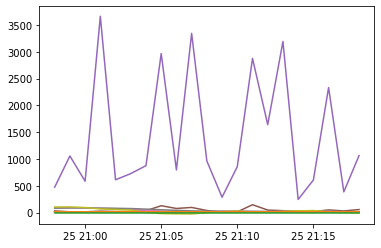

In [13]:
for symbol in symbols.keys():
    print(symbols[symbol].bollinger_bands)
    plt.plot(symbols[symbol].bollinger_bands)
    plt.show()

In [ ]:
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()

#BTC = 'buy'
#ETH = 'buy'
#USDT = 'buy'

scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    sleep(3)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    max_score = max(scores.values())
    best_assets = [asset for asset in scores.keys() if scores[asset] == max_score]
    print('best_assets: ', best_assets)

    if not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol

best_assets:  ['USDT']
best_assets:  ['USDT']
best_assets:  ['ETH', 'USDT']
best_assets:  ['BTC', 'BNB']


In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()